<a href="https://colab.research.google.com/github/pakkei1212/SMU_AML_PROJ/blob/main/Hotel_LogisticRegression_Split_Data_First.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!pip install optuna

In [87]:
#@title connect google drive

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_AML_PRO/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SMU_MITB_AML_PRO


In [88]:
from re import VERBOSE
import optuna
from sklearn.metrics import (
    f1_score, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import joblib
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import tqdm
import shap

from hotel_preprocessing import clean_data, extract_features, drop_columns, XYPreprocessor

RANDOM_STATE = 2025
VERBOSE = 2

In [89]:
raw_hotel_data = pd.read_csv("hotel_bookings.csv")
hotel_data = raw_hotel_data.copy()

In [90]:
# Checking
X_hotel_data_raw = hotel_data.drop(['is_canceled'], axis=1)
y_hotel_data_raw = hotel_data['is_canceled'].astype(int)

xyp = XYPreprocessor()
X_hotel_data_processed, y_hotel_data_processed = xyp.fit_transform(X_hotel_data_raw, y_hotel_data_raw)

print(X_hotel_data_processed.shape)
print(y_hotel_data_processed.shape)

(87377, 99)
(87377,)


In [91]:
# Combine year, month, and day columns into a single datetime column
hotel_data['arrival_date'] = pd.to_datetime(
    hotel_data['arrival_date_year'].astype(str) + '-' +
    hotel_data['arrival_date_month'] + '-' +
    hotel_data['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'  # Ensure proper month name parsing
)

# Determine the latest arrival date
last_date = hotel_data['arrival_date'].max()

# Define the cutoff date for the last 3 months
cutoff_date = last_date - pd.DateOffset(months=3)

# Split into test and train/val sets
test_data = hotel_data[hotel_data['arrival_date'] > cutoff_date].reset_index(drop=True)
train_val_data = hotel_data[hotel_data['arrival_date'] <= cutoff_date].reset_index(drop=True)

# Optional summary
print(f"Latest arrival date: {last_date.date()}")
print(f"Cutoff date for test set: {cutoff_date.date()}")
print(f"Train/Validation samples: {len(train_val_data)}")
print(f"Test samples: {len(test_data)}")

Latest arrival date: 2017-08-31
Cutoff date for test set: 2017-05-31
Train/Validation samples: 103505
Test samples: 15885


In [92]:
hotel_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01


In [93]:
X_train_val_raw = train_val_data.drop(['is_canceled'], axis=1)
y_train_val_raw = train_val_data['is_canceled'].astype(int)

X_test_raw = test_data.drop(['is_canceled'], axis=1)
y_test_raw = test_data['is_canceled'].astype(int)

In [94]:
class ClassifierModelWithOptuna:
    def __init__(self, X, y, model_class, param_space_func, n_trials=20, n_splits=5):
        """
        model_class: e.g., LogisticRegression
        param_space_func: callable(trial) → dict of model kwargs
        """
        self.X_raw = X # Store raw data
        self.y_raw = y # Store raw data
        self.model_class = model_class
        self.param_space_func = param_space_func
        self.n_trials = n_trials
        self.n_splits = n_splits

        self.best_model = None
        self.best_params = None
        self.study = None
        self.preprocessor = XYPreprocessor() # Initialize preprocessor once

    def objective(self, trial):
        params = self.param_space_func(trial)
        model = self.model_class(**params)

        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=RANDOM_STATE)
        scores = []

        for train_idx, val_idx in skf.split(self.X_raw, self.y_raw):
            X_train_raw, X_val_raw = self.X_raw.iloc[train_idx], self.X_raw.iloc[val_idx]
            y_train_raw, y_val_raw = self.y_raw.iloc[train_idx], self.y_raw.iloc[val_idx]

            # Joint preprocessing of X and y
            preprocessor = XYPreprocessor()
            X_train, y_train = preprocessor.fit_transform(X_train_raw, y_train_raw)
            X_val, y_val = preprocessor.transform(X_val_raw, y_val_raw)

            # Train and evaluate model
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_val)[:, 1]
            scores.append(roc_auc_score(y_val, y_pred))

        return np.mean(scores)

    def optimize(self):

        pbar = tqdm.tqdm(total=self.n_trials, desc="Optimizing Trials")

        def tqdm_callback(study, trial):
            pbar.update(1)

        self.study = optuna.create_study(direction='maximize')
        self.study.optimize(self.objective, n_trials=self.n_trials, callbacks=[tqdm_callback])

        pbar.close()

        self.best_params = self.param_space_func(self.study.best_trial)
        self.best_model = self.model_class(**self.best_params)

        # Fit the final model on the preprocessed full training/validation data
        X_train_val_processed, y_train_val_processed = self.preprocessor.fit_transform(self.X_raw, self.y_raw)
        self.best_model.fit(X_train_val_processed, y_train_val_processed)

        print("Best Parameters:", self.best_params)
        print("Best AUC Score:", self.study.best_value)

    def predict(self, X_test_raw, y_test_raw=None):
        X_test_processed, y_test_processed = self.preprocessor.transform(X_test_raw, y_test_raw)

        y_pred = self.best_model.predict(X_test_processed)
        y_prob = self.best_model.predict_proba(X_test_processed)[:, 1] if hasattr(self.best_model, 'predict_proba') else None

        if y_test_raw  is not None:
            print("\nClassification Report:")
            print(classification_report(y_test_processed, y_pred, digits=4))

            if y_prob is not None:
                auc = roc_auc_score(y_test_processed, y_prob)
                print(f"AUC Score: {auc:.4f}")

                # Plot ROC curve
                fpr, tpr, _ = roc_curve(y_test_processed, y_prob)
                plt.figure()
                plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
                plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.title("ROC Curve")
                plt.legend()
                plt.grid(True)
                plt.show()

        return y_pred

    def get_top_k_features(self, X_val_raw, y_val_raw=None, method='permutation', k=10):
      if self.best_model is None:
          print("No trained model found. Please run optimize() first.")
          return None

      X_val_processed, y_val_processed = self.preprocessor.transform(X_val_raw, y_val_raw)

      # Permutation is for linear model
      if method == 'permutation':
          result = permutation_importance(
              self.best_model,
              X_val_processed,
              y_val_processed,
              scoring='f1',
              n_repeats=5,
              random_state=RANDOM_STATE)

          importances = result.importances_mean
          feature_names = X_val_processed.columns if hasattr(X_val_processed, 'columns') else [f'feature_{i}' for i in range(X_val_processed.shape[1])]

          perm_df = pd.DataFrame({
              'feature': feature_names,
              'importance': importances
          }).sort_values('importance', ascending=False)

          print(f"\nTop {k} features by Permutation Importance:")
          return perm_df.head(k)

      # Shap is for tree models
      elif method == 'shap':
          try:
              explainer = shap.Explainer(self.best_model, X_val_processed)
              shap_values = explainer(X_val_processed)
          except Exception as e:
              print(f"Falling back to KernelExplainer due to: {e}")
              background = shap.utils.sample(X_val_processed, 100)
              explainer = shap.KernelExplainer(self.best_model.predict_proba, background)
              shap_values = explainer.shap_values(X_val_processed)

          # Handle shap_values for binary classification
          if isinstance(shap_values, list):  # binary classification case
              shap_vals = shap_values[1] if len(shap_values) > 1 else shap_values[0]
          else:
              shap_vals = shap_values.values

          abs_mean_shap = np.abs(shap_vals).mean(axis=0)
          feature_names = X_val_processed.columns if hasattr(X_val_processed, 'columns') else [f'feature_{i}' for i in range(X_val_processed.shape[1])]

          shap_df = pd.DataFrame({
              'feature': feature_names,
              'importance': abs_mean_shap
          }).sort_values('importance', ascending=False)

          print(f"\nTop {k} features by SHAP Importance:")
          return shap_df.head(k)

      else:
          raise ValueError("Method must be either 'permutation' or 'shap'")

    def export_model(self, model_path='best_model.pkl', info_path='best_model_info.json'):
        if self.best_model is None:
            print("No best model to export.")
            return

        joblib.dump(self.best_model, model_path)
        info = {
            'best_params': self.best_params,
            'best_score': float(self.study.best_value)
        }
        with open(info_path, 'w') as f:
            json.dump(info, f, indent=2)

        print(f"Model saved to {model_path}")
        print(f"Info saved to {info_path}")

    def import_model(self, model_path='best_model.pkl', info_path='best_model_info.json'):
        self.best_model = joblib.load(model_path)
        with open(info_path, 'r') as f:
            info = json.load(f)
            self.best_params = info['best_params']

Optimizing Trials:   0%|          | 0/15 [00:00<?, ?it/s][I 2025-06-08 14:35:49,905] A new study created in memory with name: no-name-f51bf81f-d310-4a5d-91f1-2b0f84b3d1b1
[I 2025-06-08 14:36:41,011] Trial 0 finished with value: 0.8875553619327062 and parameters: {'solver': 'lbfgs', 'C': 1.1310760415799723, 'class_weight': None}. Best is trial 0 with value: 0.8875553619327062.
Optimizing Trials: 100%|██████████| 15/15 [23:38<00:00, 94.58s/it] 


Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 9.350185214170827, 'class_weight': 'balanced', 'max_iter': 1000}
Best AUC Score: 0.890958231694247

Classification Report:
              precision    recall  f1-score   support

           0     0.9243    0.6083    0.7337      8512
           1     0.5589    0.9088    0.6922      4649

    accuracy                         0.7145     13161
   macro avg     0.7416    0.7586    0.7130     13161
weighted avg     0.7952    0.7145    0.7191     13161

AUC Score: 0.8321


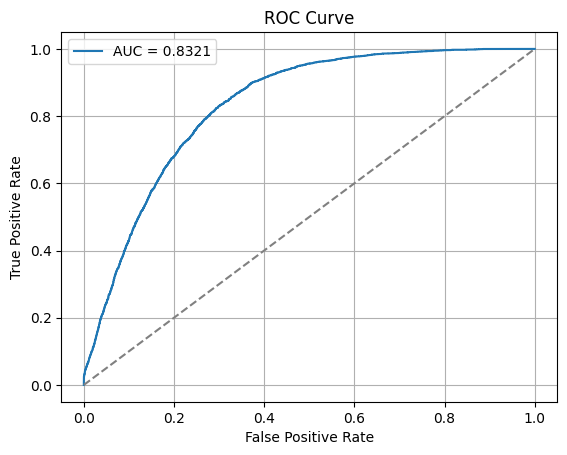

array([1, 0, 1, ..., 0, 1, 1])

In [95]:
# Define parameter search space for LogisticRegression
def logistic_param_space(trial):
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
    penalty = "l2" if solver == "lbfgs" else trial.suggest_categorical("penalty", ["l1", "l2"])

    params = {
        "solver": solver,
        "penalty": penalty,
        "C": trial.suggest_float("C", 1e-3, 10.0, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "max_iter": 1000
    }

    return params

# Train
model = ClassifierModelWithOptuna(
    X=X_train_val_raw, y=y_train_val_raw,
    model_class=LogisticRegression,
    param_space_func=logistic_param_space,
    n_splits=5,
    n_trials=15
)
model.optimize()

# Evaluate
model.predict(X_test_raw, y_test_raw)

In [96]:
# Export the model
model.export_model()

Model saved to best_model.pkl
Info saved to best_model_info.json


In [97]:
# Import the model
model.import_model()
print(model.best_params)

{'solver': 'liblinear', 'penalty': 'l1', 'C': 9.350185214170827, 'class_weight': 'balanced', 'max_iter': 1000}


In [98]:
model.get_top_k_features(X_test_raw, y_test_raw, method='permutation', k=10)


Top 10 features by Permutation Importance:


,feature,importance
17,lead_time_log,0.069018
98,agent_binned_Other,0.067563
92,country_binned_PRT,0.056753
14,required_car_parking_spaces,0.041133
15,total_of_special_requests,0.030834
21,room_type_match,0.021297
97,agent_binned_Not Specified,0.018364
18,booking_changes_log,0.017693
59,assigned_room_type_A,0.017312
95,agent_binned_14.0,0.013690
